In [121]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os

# Preparing Metadata/Labels

In [153]:
all_files = glob.glob("/mnt/b/Google_Drive/PhD/Project with Janet/Kohler_Corrected/*.HDR")

file_names = pd.concat({n: pd.DataFrame([{FN.split("/")[-1][13:-4]:FN for FN in all_files if FN.split("/")[-1][4] == str(n) }]).T for n in [1,2]})

file_names.reset_index(inplace = True)
file_names.columns = ["TMA", "Core", "envi_loc"]

In [154]:
all_files = glob.glob("/mnt/b/Google_Drive/PhD/Project with Janet/Label_Images/TMA*/*.png")

label_names = pd.concat({n: pd.DataFrame([{FN.split("/")[-1][8:-4]:FN for FN in all_files if FN.split("/")[-2][-1] == str(n) }]).T for n in [1,2]})

label_names.reset_index(inplace = True)
label_names.columns = ["TMA", "Core", "Annotation_loc"]

In [155]:
file_locations = label_names.merge(file_names, left_on = ["TMA", "Core"], right_on = ["TMA", "Core"])

In [156]:
metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx"
              , sheet_name = "reformatted")

In [157]:
metadata = metadata.dropna(subset = ["TMA"]).query("TMA in [1,2]").merge(file_locations
                                                              , left_on = ["TMA", "TMA site"]
                                                              , right_on = ["TMA", "Core"])

In [158]:
metadata.shape

(117, 19)

In [159]:
metadata.head()

,TMA,TMA site,gender,Patient nu,Corrected Site AJCC/UICC,Pathogical Stage,T stage,N stage,ECS,diff,advancing front type,Overall Death,survival (months),recurrence,radiotherapy,Diagnosis Age,Core,Annotation_loc,envi_loc
0,1.0,G6,m,3143,FOM,pT4N0,4,0,no,mod,islands,yes,111.0,yes,yes,58.0,G6,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
1,1.0,C10,m,3169,FOM,pT3N1M0,3,1,no,poor,non cohesive,yes,17.0,NaN,yes,63.0,C10,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
2,1.0,D9,m,3237,other,pT4aN2aMx,4a,2a,yes,mod well,non-cohesive,yes,2.0,yes,yes,59.0,D9,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
3,1.0,F4,f,3241,FOM,pT2N2bMx,2,2b,yes,NaN,non-coherent,yes,81.0,no,yes,75.0,F4,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...
4,1.0,C11,m,3248,FOM,pT2N2bM0,2,2b,yes,mod,non-cohesive,yes,55.0,no,yes,67.0,C11,/mnt/b/Google_Drive/PhD/Project with Janet/Lab...,/mnt/b/Google_Drive/PhD/Project with Janet/Koh...


# Import some data

In [9]:
import spectral
import UNETprocess

In [176]:
sample = metadata.sample(5)
fn = np.array(sample["envi_loc"])

In [178]:
images = {name: spectral.envi.open(name).load() for name in sample["envi_loc"]}

Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.


In [210]:
np.argmin(np.abs(1340 - wn))

88

In [217]:
tab = pd.concat({key.split("/")[-1][13:-4]: pd.DataFrame(value.reshape(-1, value.shape[-1])) for key, value in images.items()})
tab.columns = wn

Text(0.5, 0, 'Wavenumber $(cm^{-1})$')

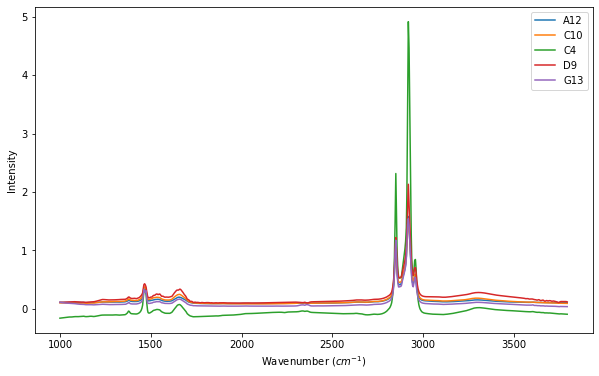

In [225]:
ax = tab.groupby(level = 0).mean().T.plot(figsize = (10,6))
ax.set_ylabel("Intensity")
ax.set_xlabel("Wavenumber $(cm^{-1})$")

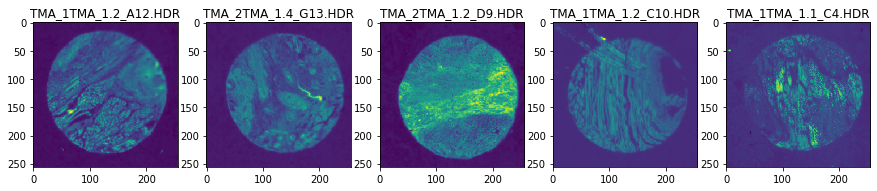

In [179]:
fig, axes = plt.subplots(ncols = 5, figsize = (15,3))

for im, title, ax in zip(images.values(), images.keys(), axes.flatten()):
    
    ax.set_title(title.split("/")[-1])
    ax.imshow(im[:,:,169].squeeze())

# Image_Generator

In [180]:
from keras.preprocessing.image import ImageDataGenerator

In [194]:
x_train = np.stack(images.values())
y_train = np.array(list(images.keys()))

imgen = ImageDataGenerator(
                          rotation_range = 90,
                          featurewise_center = True,
                          samplewise_center = True,
                          featurewise_std_normalization = True,
                          samplewise_std_normalization = True,
                          width_shift_range = (0.3,0.3),
                          height_shift_range = (0.3,0.3),
                          zoom_range = (0.9, 0.9),
                          horizontal_flip = True,
                          vertical_flip = True,
                          zca_whitening = False
                          )
imgen.fit(x_train)

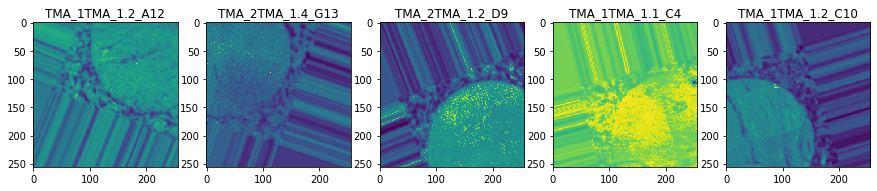

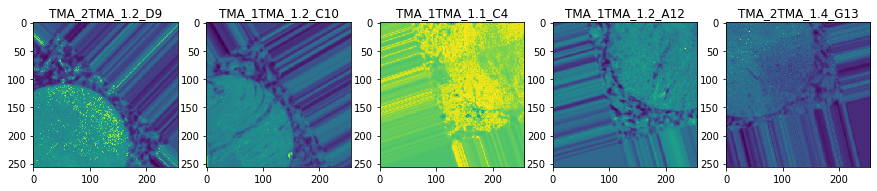

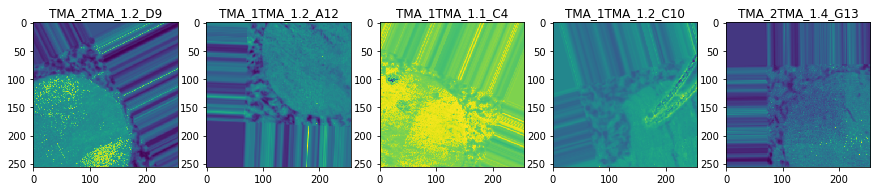

In [199]:
i = 0

for ims, titles in imgen.flow(x_train, y_train, batch_size = 5):

    fig, axes = plt.subplots(ncols = 5, figsize = (15,3))

    for im, title, ax in zip(ims, titles, axes.flatten()):

        name = title.split("/")[-1][:-4]

        ax.set_title(f"{name}")
        ax.imshow(im.mean(axis = 2).squeeze())
    
    if i >= 2:
        break
        
    else:
        i +=1

## U-Net

In [198]:
import UNET

Hello


In [ ]:
UNET.UNET(3, im.shape+(1,))